# Tree topologies with PyTTN

Import libraries

In [1]:
import numpy as np
import time
import sys
import h5py
import scipy
import copy
from numba import jit
import matplotlib.pyplot as plt 
%matplotlib inline

Import PyTTN dependencies

In [2]:
from pyttn import *

# Function to visualise tree diagrams
from pyttn.utils import visualise_tree

### Matrix Product States

Matrix product states (MPS) are quantum states of many particles written in the form 

$|\Psi\rangle = \sum_{\sigma_1,...,\sigma_L} A^{\sigma_1}A^{\sigma_2}...A^{\sigma_L-1}A^{\sigma_L} |\sigma_1,...,\sigma_L\rangle$

In [3]:
# Number of sites in MPS
N = 10

# Maximum bond dimension
chi = 8

# Vector of dimensions of the local Hilbert space in the physical nodes
dims = [2 for i in range(N)]

Tree tensor networks are created using the `ntreeBuilder`. Its function `mps_tree` creates an MPS with maximum virtual-bond dimension `chi`, and with the physical dimensions specified in `dims`.

In [4]:
topo = ntreeBuilder.mps_tree(dims,chi)

### Visualising Tensor Networks

The function `visualise_tree` plots the tree diagram of the tensor network. It works along with `matplotlib`.

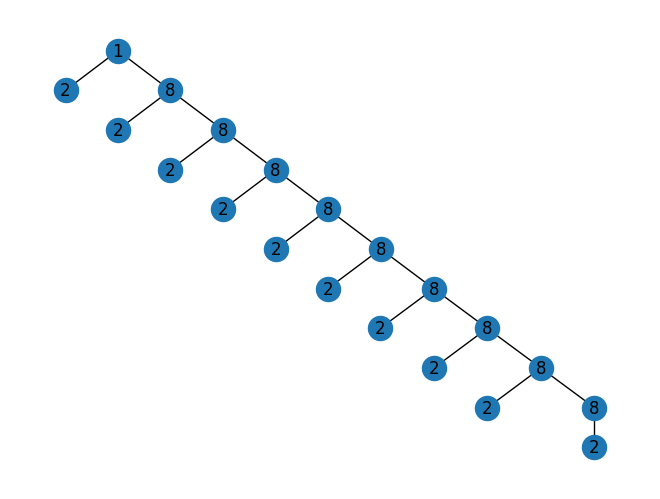

In [5]:
# Creating a figure is not needed here, but it is important 
# to remember it inside .py scripts
plt.figure()

# Plot tree diagram
visualise_tree(topo)
plt.show()

The MPS is represented as a tree diagram in which the leaves (the nodes without children) represent the physical nodes, while the parent nodes form the "skeleton" of the MPS.

The numbers in each node represent the dimension of the bond above it (note that since tree tensor networks are loop free, every node will have just one parent node). For leaf nodes, this number indicates the dimension of the physical index of the MPS, and therefore the dimension of the Hilbert space of the degree of freedom they encode. In the code above, the physical dimensions are given by the vector `dim`. For the "skeleton" nodes, that number specifies the dimension of the virtual bonds connecting the site tensors of the MPS. The bond dimension is initialised to its maximum value `chi`. The node at the top of the tree is the root and has dimension 1—a scalar.

### Sanitise tree diagrams

The tensor network diagram can be optimised in a few ways to make calculations more efficient.

When working with large physical Hilbert spaces (i.e. large dimensions in the leaf nodes), it can be useful to work in a reduced-dimensional basis. To implement this transformation, the code inserts an extra node between the bond nodes (the ones that give shape to the MPS) and the physical nodes (the leaves). These basis nodes define a time-dependent local basis of a reduced dimension for the physical nodes. They are implemented as an attribute of `ntreeBuilder`.

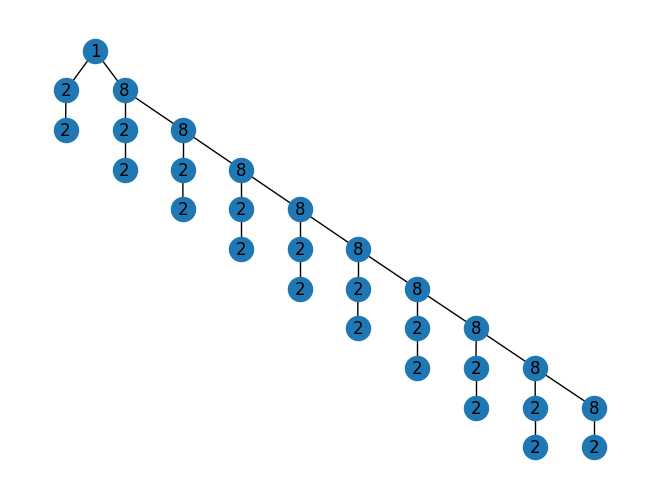

In [6]:
ntreeBuilder.insert_basis_nodes(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

Another useful optimisation is to contract *bond* matrices that are connected to only two tensors. This is important for algorithms with adaptive bond dimension, since allowing for bond matrices as site tensors would stop the adaptation of the bond dimension from working.

The function `collapse_bond_matrices` contracts any bond matrix and tensors that are not physical or local-transformation nodes. 

In the tensor network above, this happens to the root node, which is contracted with the node to its right. That node becomes the new root of the tree, and again will have dimension 1.

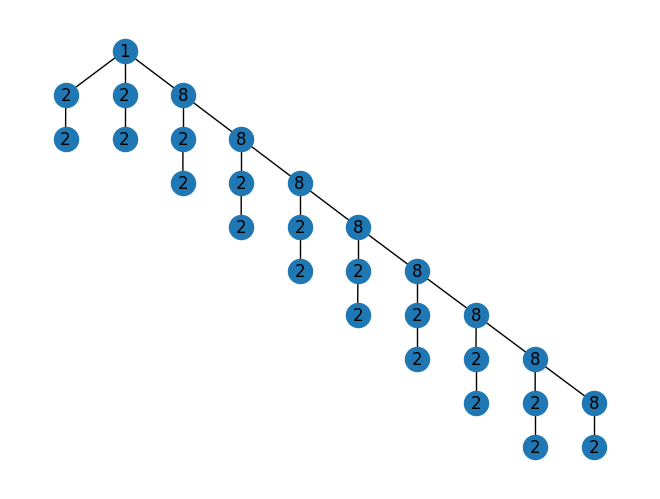

In [7]:
ntreeBuilder.collapse_bond_matrices(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

One last useful optimisation is to make sure that bond dimensions being used are not larger than using a full basis for the degrees of freedom. This reduces the bond dimension in some bonds from its maximum value (to which it was initialised) to the effective bond dimension they encode.

In the example below, this reduces the dimension of the last two bonds of the MPS from 8 to 4 and 2.

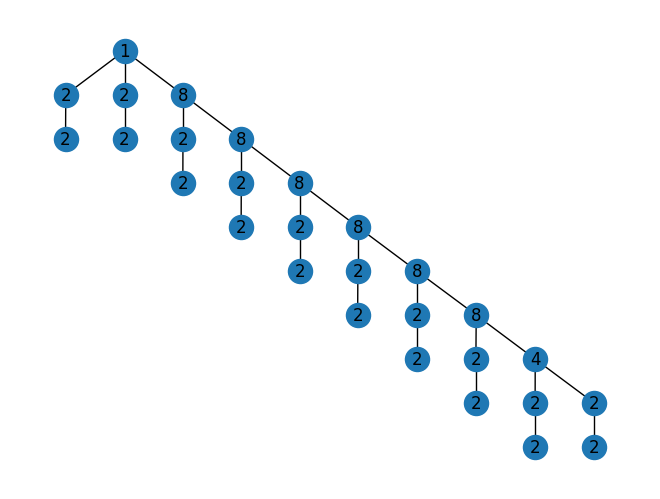

In [8]:
ntreeBuilder.sanitise_bond_dimensions(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

All this processing of the tree diagram can be done at the same time with the function `sanitise` of `ntreeBuilder`—this is how it will be done for the rest of this tutorial.

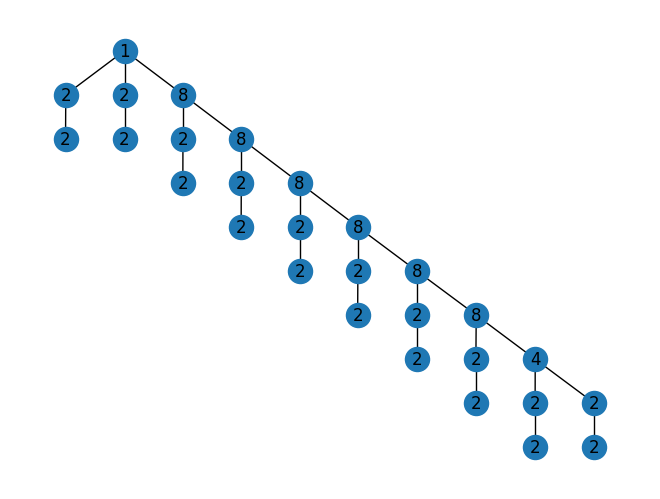

In [9]:
ntreeBuilder.sanitise(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

### ML-MCTDH ansatz

Beyond Matrix Product States, the ML-MCTDH ansatz (short for Multi-Layer Multi-Configuration Time-Dependent Hartree ansatz) is a powerful method to simulate quantum many-body systems. The wavefunction is represented in a tree structure with several layers for the different levels of complexity.

The ML-MCTDH tree is constructed using the `mlmctdh_tree` function of `ntreeBuilder`. As with MPS, `chi` sets the maximum bond dimension, and `dims` specifies the dimensions of the physical bonds.

The parameter `degree` set the maximum number of children that a node can have. Depending on it, the tree will be binary, ternary, etc. The degree of the tree controls its depth by determining the number of layers needed to construct the number of physical degrees of freedom set by `dims`.

The nodes are ordered according to a *pre-order depth-first traversal* labelling of the nodes. In practice, this means that the left-most node is the first physical degree of freedom, and increasing towards the right.

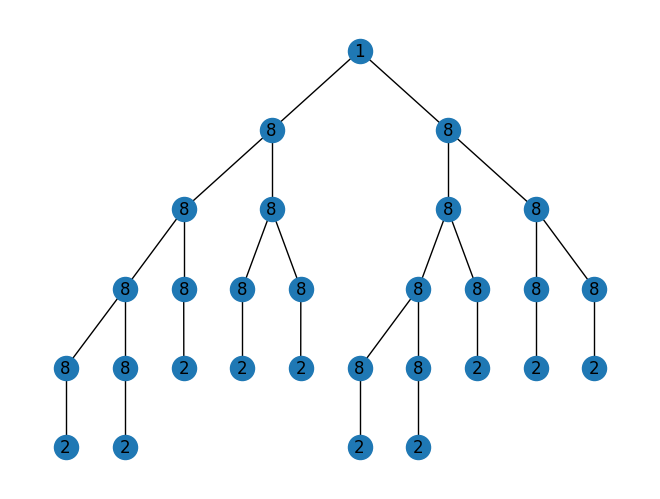

In [10]:
# Always larger than 1. Max number of child nodes for each node
degree = 2

topo = ntreeBuilder.mlmctdh_tree(dims, degree, chi)

# Plot tree diagram
visualise_tree(topo)
plt.show()

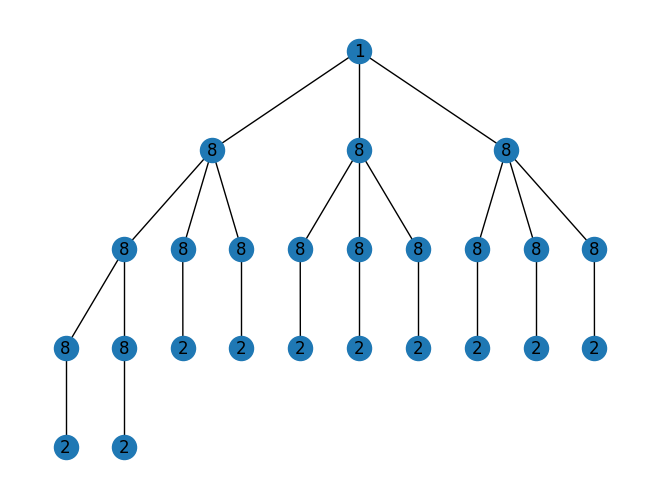

In [17]:
# Always larger than 1. Max number of child nodes for each node
degree = 3

topo = ntreeBuilder.mlmctdh_tree(dims, degree, chi)

# Plot tree diagram
visualise_tree(topo)
plt.show()

### Custom tree building

One may wish to create a tree with a topology different to an MPS or the ML-MCTDH ansatz. The function `ntree` can be used for that purpose, by writing the desired tree topology in parentheses notation.

In this notation, each pair of parentheses encloses a subtree, where the root node is followed by its child nodes inside parentheses. For example, the notation `(1(2)(3))` describes a tree with root node `1`, and two child nodes, `2` and `3`. Nested parentheses represent deeper levels of the tree: in the tree `(1(2(4)(5))(3))`, the node 2 has two child nodes itself, `4` and `5`.

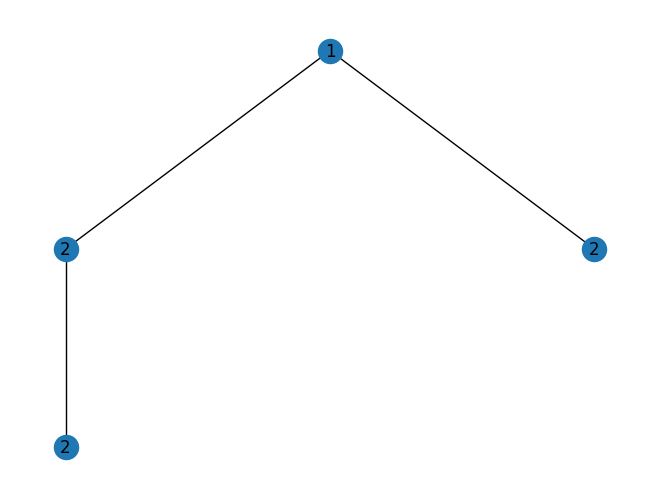

In [11]:
topo = ntree("(1(2(2))(2))")

visualise_tree(topo)
plt.show()

To store and visualise the tree topology, the diagram can be printed in parentheses notation.

In [12]:
print(topo)

ntree : (1(2(2))(2));



### Adding MPS subtrees

A useful possibility of `ntreeBuilder` is to append MPS chains to custom trees. This is done with the function `mps_subtree`. It defines an MPS with maximum bond dimension `chi` and physical Hilbert-space dimensions `dims`. 

The MPS is attached to the node specified in the first argument of the function—in the example below, `topo()[1]`. In general, `topo()` specifies the root node of the tree. Nodes are ordered from left to right, so `topo()[0]` specifies the left child of the root node and `topo()[1]` specifies the right child node. The child of the left node could be selected as `topo()[0][0]`, and so on.

The last parameter of `mps_subtree`, if included, sets the dimension of the basis nodes, that implement a local Hilbert-space transformation between the physical nodes and the "skeleton" of the MPS. When omitted, the `sanitise` function will insert them automatically.

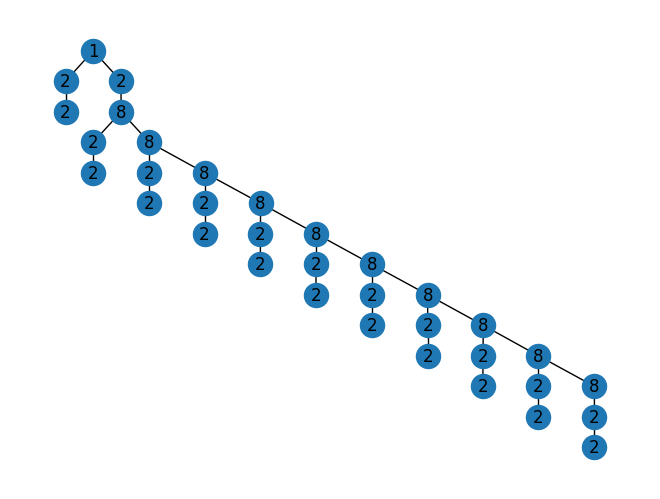

In [13]:
ntreeBuilder.mps_subtree(topo()[1], dims, chi, 2)

# Plot tree diagrams
visualise_tree(topo)
plt.show()

Again, sanitising the tree is an important step to optimise the tree for internal processing. The `sanitise` function runs the three sanitation steps simultaneously.

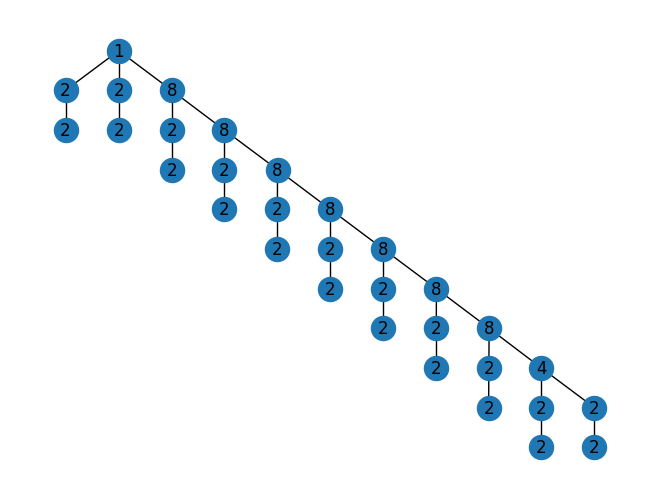

In [14]:
ntreeBuilder.sanitise(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()

### Adding ML-MCTDH subtrees

Instead of appending an MPS to the tree, one can instead append an ML-MCTDH tree. This is done with the function `mlmctdh_subtree`. It defines an ML-MCTDH tree of a specific `degree` with maximum bond dimension `chi` and physical Hilbert-space dimensions `dims`. 

As with the MPS subtree, the ML-MCTDH subtree is attached to the node addressed in the first argument of the function. In the example below, it will be attached to the second child (`[1]`) of the root node (`topo()`), that is, `topo()[1]`.

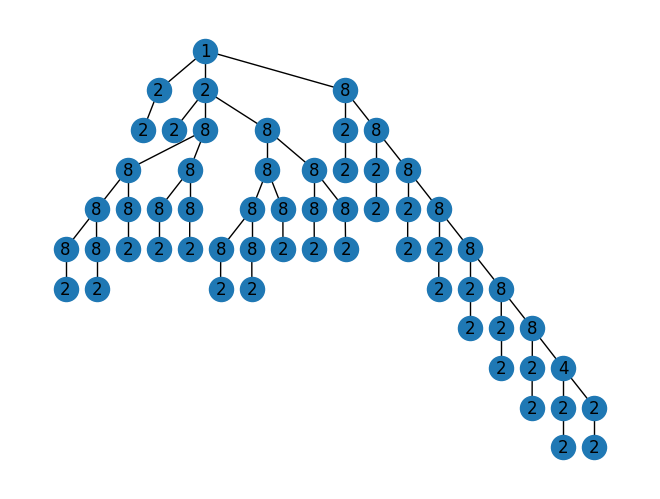

In [15]:
degree = 2

ntreeBuilder.mlmctdh_subtree(topo()[1], dims, degree, chi)

# Plot tree diagram
visualise_tree(topo)
plt.show()

Again, sanitising the tree is an important step to optimise the tree for internal processing. The `sanitise` function runs the three sanitation steps simultaneously.

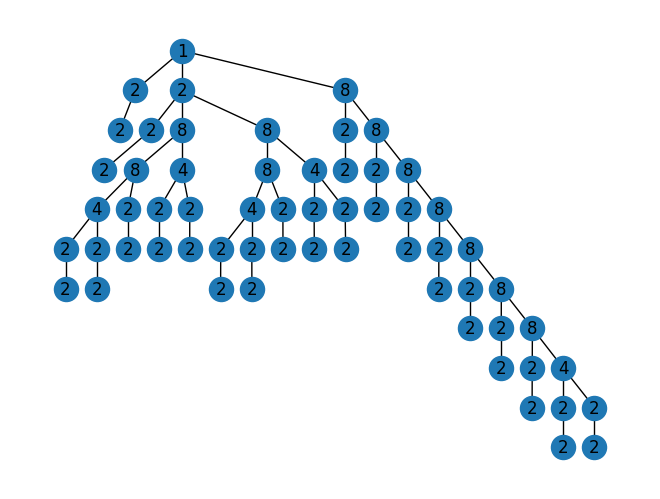

In [16]:
ntreeBuilder.sanitise(topo)

# Plot tree diagram
visualise_tree(topo)
plt.show()